In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from xgboost import XGBClassifier
from datetime import datetime
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, confusion_matrix, roc_auc_score
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

### Summary of streamlined approach

1. Loading full user dataset
2. Data preprocessing
3. Tokenising 'description' with TF-IDF
4. Using PCA to reduce dimensions of transformed dataset
5. Modelling with XGBoost/Random Forest/Logistic Regression

In [2]:
url = 'https://raw.githubusercontent.com/amiism/DSA4263/main/data/UsersData/combined_users_full.csv'
df = pd.read_csv(url)
df

,id,name,screen_name,statuses_count,followers_count,friends_count,favourites_count,listed_count,url,lang,...,description,contributors_enabled,following,created_at,timestamp,crawled_at,updated,test_set_1,test_set_2,Type
0,531256710,Christel Martillo,Martillodig,12515,787,1947,1,0,NaN,en,...,Lover of life - need I say more!,NaN,NaN,Tue Mar 20 12:07:58 +0000 2012,2012-03-20 13:07:58,2014-05-05 23:23:09,2016-03-15 15:39:59,NaN,1.0,Bot
1,72081097,TMJ-ON CstSrv Jobs,tmj_on_cstsrv,117,300,247,0,30,https://t.co/DByWt45HZj,en,...,Follow this account for geo-targeted Customer ...,NaN,NaN,Sun Sep 06 17:29:17 +0000 2009,2009-09-06 19:29:17,2016-03-15 13:49:10,2016-03-15 13:49:10,NaN,NaN,Bot
2,327060670,Federico Floria,Airolf,25930,10854,10606,418,66,http://t.co/0mQHlgxEmD,it,...,"Mika e' la mia vita, Supernatural la mia passi...",NaN,NaN,Thu Jun 30 22:59:43 +0000 2011,2011-07-01 00:59:43,2014-04-27 23:20:27,2016-03-15 14:13:49,1.0,NaN,Bot
3,2398910547,Southern Fields,southern_fields,730,1132,914,557,1,NaN,en,...,"Just a plain ol' country boy. I love God, Geor...",NaN,NaN,Mon Mar 10 07:48:09 +0000 2014,2014-03-10 08:48:09,2014-05-02 23:22:50,2016-03-15 14:16:12,1.0,NaN,Bot
4,69218476,Vanessa,Vanessa8w3v,1,153,568,0,0,http://xurl.jp/pc3a,NaN,...,NaN,NaN,NaN,1251353539000L,2009-08-27 08:12:19,2010-11-07 11:10:52,2016-03-14 17:08:43,NaN,NaN,Bot
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11012,2377083871,Ozella Failla,OzellaFailla,35,4,37,0,0,NaN,en,...,NaN,NaN,NaN,Fri Mar 07 13:01:10 +0000 2014,2014-03-07 14:01:10,2014-05-05 00:20:53,2016-03-15 15:08:58,NaN,NaN,Bot
11013,2370930889,Bao Faykosh,BaoFaykosh,57,2,42,0,0,NaN,en,...,NaN,NaN,NaN,Mon Mar 03 20:45:36 +0000 2014,2014-03-03 21:45:36,2014-05-05 00:20:28,2016-03-15 15:06:00,NaN,NaN,Bot
11014,2213122314,Lavonia Homesley,LavoniaHomesley,131,26,48,4,0,NaN,en,...,NaN,NaN,NaN,Sun Nov 24 21:47:20 +0000 2013,2013-11-24 22:47:20,2014-05-05 00:20:37,2016-03-15 15:07:05,NaN,NaN,Bot
11015,233444535,LaRosa,LaRosa_N,373,39,133,6,1,NaN,en,...,Just someone with an inquiring mind.,NaN,NaN,Mon Jan 03 07:11:54 +0000 2011,2011-01-03 08:11:54,2015-05-01 16:06:44,2016-03-15 15:58:07,1.0,0.0,Genuine


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11017 entries, 0 to 11016
Data columns (total 43 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   id                                  11017 non-null  int64  
 1   name                                11016 non-null  object 
 2   screen_name                         11017 non-null  object 
 3   statuses_count                      11017 non-null  int64  
 4   followers_count                     11017 non-null  int64  
 5   friends_count                       11017 non-null  int64  
 6   favourites_count                    11017 non-null  int64  
 7   listed_count                        11017 non-null  int64  
 8   url                                 3508 non-null   object 
 9   lang                                10017 non-null  object 
 10  time_zone                           5015 non-null   object 
 11  location                            4908 

In [4]:
df.isnull().sum()

id                                        0
name                                      1
screen_name                               0
statuses_count                            0
followers_count                           0
friends_count                             0
favourites_count                          0
listed_count                              0
url                                    7509
lang                                   1000
time_zone                              6002
location                               6109
default_profile                        9540
default_profile_image                 10945
geo_enabled                            7723
profile_image_url                         0
profile_banner_url                     6198
profile_use_background_image           1514
profile_background_image_url_https     1000
profile_text_color                     1000
profile_image_url_https                1000
profile_sidebar_border_color           1000
profile_background_tile         

In [5]:
# retaining more useful features

df = df[["statuses_count", "followers_count", "friends_count", "favourites_count", "listed_count", "default_profile", "default_profile_image",
"geo_enabled", "profile_use_background_image", "profile_background_tile", "utc_offset", "time_zone", "description", "created_at", "location", "lang",
"Type"]]
df

,statuses_count,followers_count,friends_count,favourites_count,listed_count,default_profile,default_profile_image,geo_enabled,profile_use_background_image,profile_background_tile,utc_offset,time_zone,description,created_at,location,lang,Type
0,12515,787,1947,1,0,1.0,NaN,NaN,1.0,NaN,NaN,NaN,Lover of life - need I say more!,Tue Mar 20 12:07:58 +0000 2012,NaN,en,Bot
1,117,300,247,0,30,NaN,NaN,1.0,1.0,NaN,-14400.0,Eastern Time (US & Canada),Follow this account for geo-targeted Customer ...,Sun Sep 06 17:29:17 +0000 2009,Ontario,en,Bot
2,25930,10854,10606,418,66,1.0,NaN,NaN,1.0,NaN,NaN,NaN,"Mika e' la mia vita, Supernatural la mia passi...",Thu Jun 30 22:59:43 +0000 2011,abruzzo-italy,it,Bot
3,730,1132,914,557,1,1.0,NaN,1.0,1.0,NaN,NaN,NaN,"Just a plain ol' country boy. I love God, Geor...",Mon Mar 10 07:48:09 +0000 2014,NaN,en,Bot
4,1,153,568,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1251353539000L,NaN,NaN,Bot
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11012,35,4,37,0,0,NaN,NaN,NaN,1.0,1.0,NaN,NaN,NaN,Fri Mar 07 13:01:10 +0000 2014,NaN,en,Bot
11013,57,2,42,0,0,NaN,NaN,NaN,1.0,1.0,NaN,NaN,NaN,Mon Mar 03 20:45:36 +0000 2014,NaN,en,Bot
11014,131,26,48,4,0,NaN,NaN,NaN,1.0,1.0,NaN,NaN,NaN,Sun Nov 24 21:47:20 +0000 2013,NaN,en,Bot
11015,373,39,133,6,1,NaN,NaN,NaN,1.0,NaN,-21600.0,Mountain Time (US & Canada),Just someone with an inquiring mind.,Mon Jan 03 07:11:54 +0000 2011,Illinois,en,Genuine


In [6]:
# Function to convert mixed date formats in 'created_at' to datetime objects
def convert_created_at(date_entry):
    try:
        # Assuming the entry is a datetime string
        return pd.to_datetime(date_entry, errors='coerce')
    except ValueError:
        # If it fails, assume it's a numeric timestamp in milliseconds
        try:
            timestamp = int(str(date_entry).rstrip('L'))
            return datetime.utcfromtimestamp(timestamp / 1000).replace(tzinfo=None)
        except ValueError:
            # Return NaT for unconvertible formats
            return pd.NaT

In [7]:
# Apply the conversion function to the 'created_at' column
df['created_at'] = df['created_at'].apply(convert_created_at)

# Ensure all datetime objects are tz-naive
df['created_at'] = df['created_at'].apply(lambda x: x.replace(tzinfo=None) if x is not pd.NaT else pd.NaT)

# Calculate the account age in days, handling NaT values by replacing them with a default or excluding them
now = datetime.now().replace(tzinfo=None)
df['account_age_days'] = df['created_at'].apply(lambda x: (now - x).days if x is not pd.NaT else np.nan)

# Drop created_at in favour of account_age_days
df.drop(['created_at'], axis=1, inplace=True)

<ipython-input-7-989b286a3abd>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['created_at'] = df['created_at'].apply(convert_created_at)
<ipython-input-7-989b286a3abd>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['created_at'] = df['created_at'].apply(lambda x: x.replace(tzinfo=None) if x is not pd.NaT else pd.NaT)
<ipython-input-7-989b286a3abd>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead



In [8]:
# Fill missing binary features with 0 (assuming NaN means feature is absent)
binary_features = ['default_profile', 'default_profile_image', 'geo_enabled', 'profile_use_background_image', 'profile_background_tile']
df[binary_features] = df[binary_features].fillna(0)

<ipython-input-8-6956769c445d>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[binary_features] = df[binary_features].fillna(0)


In [9]:
# Fill missing 'utc_offset' with median (or any other strategy you deem fit)
df['utc_offset'] = df['utc_offset'].fillna(df['utc_offset'].median())

<ipython-input-9-50b60c7478cd>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['utc_offset'] = df['utc_offset'].fillna(df['utc_offset'].median())


In [10]:
# Transform 'description' into a binary feature: 1 if present, 0 if missing
df['has_description'] = df['description'].apply(lambda x: 0 if pd.isnull(x) else 1)

<ipython-input-10-ae9e95e2a61d>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['has_description'] = df['description'].apply(lambda x: 0 if pd.isnull(x) else 1)


In [11]:
# Handling categorical variables: 'time_zone', 'lang', and 'location'
categorical_features = ['time_zone', 'lang', 'location']
df[categorical_features] = df[categorical_features].fillna('missing')  # Fill missing values with a placeholder

<ipython-input-11-027d98125a9c>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[categorical_features] = df[categorical_features].fillna('missing')  # Fill missing values with a placeholder


In [12]:
# One-hot encoding for categorical features
df = pd.get_dummies(df, columns=categorical_features)

In [13]:
# Encoding 'Type'
df['Type'] = df['Type'].map({'Bot': 1, 'Genuine': 0})

df.head()

,statuses_count,followers_count,friends_count,favourites_count,listed_count,default_profile,default_profile_image,geo_enabled,profile_use_background_image,profile_background_tile,...,"location_台南市, 台灣",location_台湾,location_我不知道,location_日本,location_東京,location_東京 Tokyo (Japan),location_東京とロシア,location_東京都,location_神奈川県横浜市,"location_티아라 방, 말레이시아"
0,12515,787,1947,1,0,1.0,0.0,0.0,1.0,0.0,...,0,0,0,0,0,0,0,0,0,0
1,117,300,247,0,30,0.0,0.0,1.0,1.0,0.0,...,0,0,0,0,0,0,0,0,0,0
2,25930,10854,10606,418,66,1.0,0.0,0.0,1.0,0.0,...,0,0,0,0,0,0,0,0,0,0
3,730,1132,914,557,1,1.0,0.0,1.0,1.0,0.0,...,0,0,0,0,0,0,0,0,0,0
4,1,153,568,0,0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0


In [14]:
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

# Instantiate a TF-IDF Vectorizer
tfidf_vectorizer = TfidfVectorizer(stop_words=stopwords.words('english'), max_features=1000)

# Fit and transform the 'description' column
df['description'] = df['description'].fillna('')
tfidf_matrix = tfidf_vectorizer.fit_transform(df['description'])

# Convert the TF-IDF matrix to a DataFrame
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=tfidf_vectorizer.get_feature_names_out())

# Concatenate original DataFrame with the TF-IDF DataFrame
df = pd.concat([df, tfidf_df], axis=1)

# Now drop the original 'description' column as it's been vectorized
df.drop('description', axis=1, inplace=True)

df.head()

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/harrychang/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,statuses_count,followers_count,friends_count,favourites_count,listed_count,default_profile,default_profile_image,geo_enabled,profile_use_background_image,profile_background_tile,...,xx,ya,yeah,year,years,yo,york,young,youth,youtube
0,12515,787,1947,1,0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,117,300,247,0,30,0.0,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,25930,10854,10606,418,66,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,730,1132,914,557,1,1.0,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1,153,568,0,0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [15]:
# Example of how to sanitize feature names
df.columns = [cname.replace('[', '_').replace(']', '_').replace('<', '_') for cname in df.columns]

In [16]:
# Split the data into features and target variable
X = df.drop('Type', axis=1) 
y = df['Type']

In [17]:
# Splitting dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Creating a pipeline that first imputes missing values, then standardizes the data, and finally applies PCA
pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')), 
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=0.95))  # Retain 95% of the variance or choose n_components based on needs
])

# Fit and transform the training data
X_train_transformed = pipeline.fit_transform(X_train)

# Transform the test data (do not fit the PCA or imputer on the test data)
X_test_transformed = pipeline.transform(X_test)

### XGBoost

In [18]:
# Train XGBoost on the PCA-transformed dataset
model = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
model.fit(X_train_transformed, y_train)

/Users/harrychang/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, predictor=None, random_state=None, ...)

In [19]:
# Make predictions on the test set (transformed by the pipeline including PCA)
y_pred = model.predict(X_test_transformed)

# Compute probabilities instead of binary predictions for AUC-ROC
y_prob = model.predict_proba(X_test_transformed)[:, 1]

# Compute evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
auc_roc = roc_auc_score(y_test, y_prob)

# Print the evaluation metrics
print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')
print(f'AUC-ROC: {auc_roc:.4f}')

Accuracy: 0.9642
Precision: 0.9757
Recall: 0.9725
F1 Score: 0.9741
AUC-ROC: 0.9924


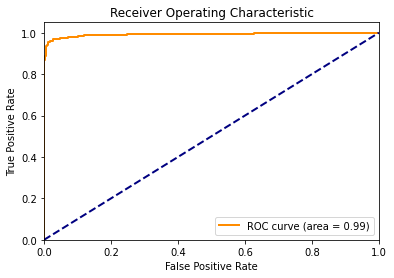

In [20]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

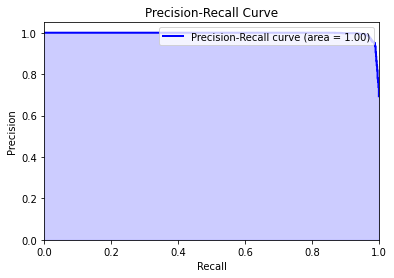

In [21]:
from sklearn.metrics import precision_recall_curve, average_precision_score

precision, recall, _ = precision_recall_curve(y_test, y_prob)
average_precision = average_precision_score(y_test, y_prob)

plt.figure()
plt.plot(recall, precision, color='blue', lw=2, label='Precision-Recall curve (area = %0.2f)' % average_precision)
plt.fill_between(recall, precision, step='post', alpha=0.2, color='blue')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall Curve')
plt.legend(loc="upper right")
plt.show()

### Random Forest

In [27]:
from sklearn.ensemble import RandomForestClassifier

# Initialize the Random Forest classifier
rf_model = RandomForestClassifier(random_state=42)

# Fit the model
rf_model.fit(X_train_transformed, y_train)

# Make predictions
rf_predictions = rf_model.predict(X_test_transformed)

# Compute probabilities instead of binary predictions for AUC-ROC
y_prob = rf_model.predict_proba(X_test_transformed)[:, 1]

# Evaluate the model
rf_accuracy = accuracy_score(y_test, rf_predictions)
rf_recall = recall_score(y_test, rf_predictions)
rf_precision = precision_score(y_test, rf_predictions)
rf_f1 = f1_score(y_test, rf_predictions)
auc_roc = roc_auc_score(y_test, y_prob)
rf_conf_matrix = confusion_matrix(y_test, rf_predictions)

# Print the evaluation metrics
print(f"Random Forest Accuracy: {rf_accuracy:.4f}")
print(f"Random Forest Recall: {rf_recall:.4f}")
print(f"Random Forest Precision: {rf_precision:.4f}")
print(f"Random Forest F1 Score: {rf_f1:.4f}")
print(f'AUC-ROC: {auc_roc:.4f}')
print("Random Forest Confusion Matrix:")
print(rf_conf_matrix)

Random Forest Accuracy: 0.9528
Random Forest Recall: 0.9548
Random Forest Precision: 0.9766
Random Forest F1 Score: 0.9656
AUC-ROC: 0.9872
Random Forest Confusion Matrix:
[[ 641   35]
 [  69 1459]]


### Logistic Regression

In [29]:
from sklearn.linear_model import LogisticRegression

# Initialize the Logistic Regression classifier
lr_model = LogisticRegression(max_iter=1000)

# Fit the model
lr_model.fit(X_train_transformed, y_train)

# Make predictions
lr_predictions = lr_model.predict(X_test_transformed)

# Compute probabilities instead of binary predictions for AUC-ROC
y_prob = lr_model.predict_proba(X_test_transformed)[:, 1]

# Evaluate the model
lr_accuracy = accuracy_score(y_test, lr_predictions)
lr_recall = recall_score(y_test, lr_predictions)
lr_precision = precision_score(y_test, lr_predictions)
lr_f1 = f1_score(y_test, lr_predictions)
auc_roc = roc_auc_score(y_test, y_prob)
lr_conf_matrix = confusion_matrix(y_test, lr_predictions)

# Print the evaluation metrics
print(f"Logistic Regression Accuracy: {lr_accuracy:.4f}")
print(f"Logistic Regression Recall: {lr_recall:.4f}")
print(f"Logistic Regression Precision: {lr_precision:.4f}")
print(f"Logistic Regression F1 Score: {lr_f1:.4f}")
print(f'AUC-ROC: {auc_roc:.4f}')
print("Logistic Regression Confusion Matrix:")
print(lr_conf_matrix)

Logistic Regression Accuracy: 0.9628
Logistic Regression Recall: 0.9660
Logistic Regression Precision: 0.9801
Logistic Regression F1 Score: 0.9730
AUC-ROC: 0.9880
Logistic Regression Confusion Matrix:
[[ 646   30]
 [  52 1476]]
